In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

## Preparation

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

raw_train_set = ImageFolder("img/", transform=transform)
BATCH_SIZE = 128

In [5]:
raw_train_set

Dataset ImageFolder
    Number of datapoints: 39209
    Root location: real_img
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
raw_train_set.class_to_idx

{'00000': 0,
 '00001': 1,
 '00002': 2,
 '00003': 3,
 '00004': 4,
 '00005': 5,
 '00006': 6,
 '00007': 7,
 '00008': 8,
 '00009': 9,
 '00010': 10,
 '00011': 11,
 '00012': 12,
 '00013': 13,
 '00014': 14,
 '00015': 15,
 '00016': 16,
 '00017': 17,
 '00018': 18,
 '00019': 19,
 '00020': 20,
 '00021': 21,
 '00022': 22,
 '00023': 23,
 '00024': 24,
 '00025': 25,
 '00026': 26,
 '00027': 27,
 '00028': 28,
 '00029': 29,
 '00030': 30,
 '00031': 31,
 '00032': 32,
 '00033': 33,
 '00034': 34,
 '00035': 35,
 '00036': 36,
 '00037': 37,
 '00038': 38,
 '00039': 39,
 '00040': 40,
 '00041': 41,
 '00042': 42}

In [7]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)


train_data, test_data = split_dataset(raw_train_set, 0.2, 42)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

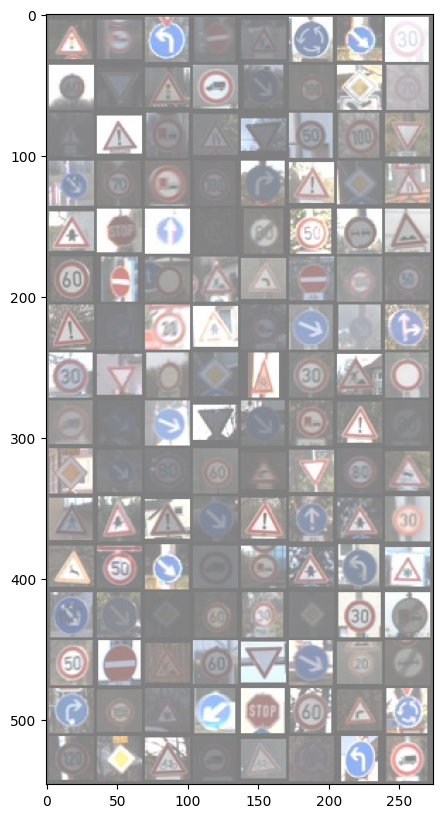

00026 00010 00034 00017 00025 00040 00038 00001 00003 00013 00026 00016 00038 00007 00012 00004 00018 00018 00010 00024 00013 00002 00007 00013 00038 00004 00010 00007 00033 00018 00012 00024 00011 00014 00035 00008 00006 00002 00009 00022 00003 00017 00015 00025 00019 00017 00007 00002 00018 00038 00001 00011 00010 00038 00038 00036 00001 00013 00015 00012 00029 00001 00025 00015 00016 00038 00038 00013 00038 00010 00018 00006 00012 00038 00005 00003 00020 00013 00005 00023 00027 00011 00018 00038 00018 00035 00011 00001 00031 00002 00038 00016 00010 00011 00034 00030 00038 00038 00012 00003 00001 00012 00001 00042 00002 00017 00025 00003 00013 00038 00000 00041 00033 00007 00030 00039 00014 00003 00020 00040 00008 00012 00029 00016 00029 00040 00034 00016


In [8]:
plt.figure(figsize=(20, 10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [9]:
_, channels, dim1, dim2 = images[0:1].size()
channels, dim1, dim2

(3, 32, 32)

In [11]:
def train(model, optimizer, loss_function=vae_loss_function, num_epochs=30, train_loader=train_loader,
          test_loader=test_loader):
    for n in range(num_epochs):
        losses_epoch = []
        for x, _ in iter(train_loader):
            x = x.to(device)
            out, means, log_var = model(x)
            loss = loss_function(x, out, means, log_var)
            losses_epoch.append(loss.item())
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()
        L1_list = []
        #     if n % 10 == 0:
        for x, _ in iter(test_loader):
            x = x.to(device)
            out, _, _ = model(x)
            L1_list.append(torch.mean(torch.abs(out - x)).item())
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        scheduler.step()

In [12]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    # imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

## Basic VAE

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, channels, dim1, dim2])
        return x_hat


class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

    def reparameterization(self, mean, var):
        # Change to proper
        epsilon = torch.randn(mean.shape).to(device)
        z = mean + epsilon * var
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [14]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=dim1 * dim2 * channels).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

train(vae, optimizer, vae_loss_function, num_epochs=30)

Epoch 0 loss 15968.344256393308, test L1 = 0.11755659190877792
Epoch 1 loss 10595.413044751174, test L1 = 0.10087932057438358
Epoch 2 loss 9117.033483737852, test L1 = 0.09399928801482724
Epoch 3 loss 8544.343288266562, test L1 = 0.09092961600230585
Epoch 4 loss 8208.250423028217, test L1 = 0.09016585986941092
Epoch 5 loss 7982.763911549638, test L1 = 0.08688486715958964
Epoch 6 loss 7817.903648314437, test L1 = 0.08641735608539274
Epoch 7 loss 7663.888439147453, test L1 = 0.08442335383545968
Epoch 8 loss 7528.643076082555, test L1 = 0.08384826839450867
Epoch 9 loss 7430.382069409378, test L1 = 0.08388700348234945
Epoch 10 loss 7356.054388278868, test L1 = 0.08287861270289268
Epoch 11 loss 7262.43317543588, test L1 = 0.08102703322806666
Epoch 12 loss 7195.980748618521, test L1 = 0.0817551751050257
Epoch 13 loss 7136.975861836255, test L1 = 0.08011089914268063
Epoch 14 loss 7057.234016728595, test L1 = 0.07953501072141432
Epoch 15 loss 7027.552010885099, test L1 = 0.08053789287805557
Ep

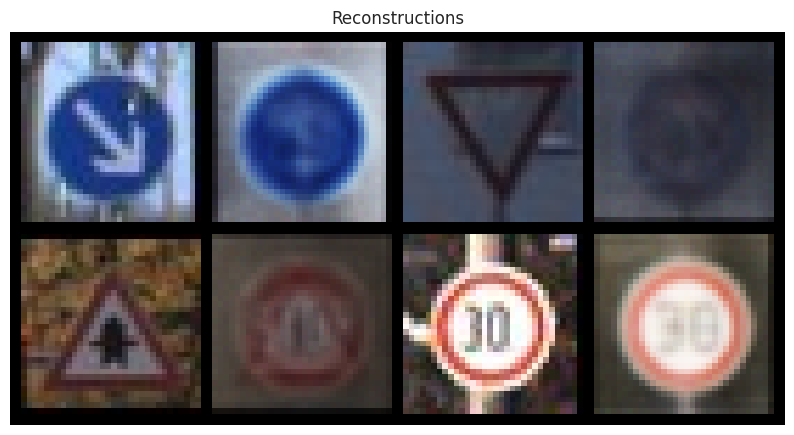

In [12]:
input_imgs, labels = next(iter(test_loader))
input_imgs = input_imgs[:4]
input_imgs.shape
visualize_reconstructions(vae, input_imgs, device)

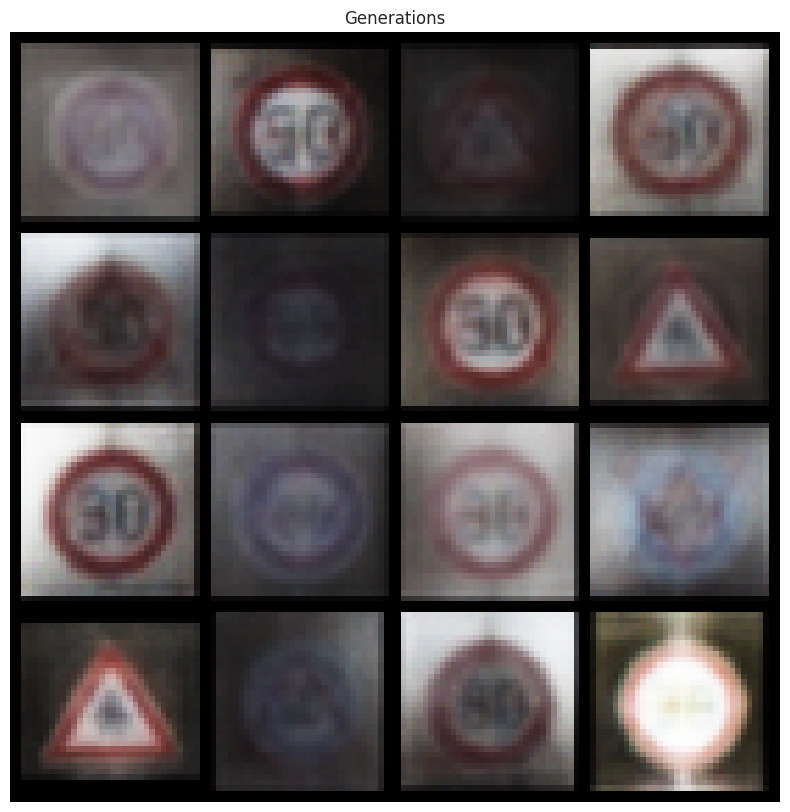

In [13]:
generate_images(vae, 16, device)

In [22]:
import os
from torchvision.utils import save_image

GENERATION_DIR = "generated_img"
if not os.path.exists(GENERATION_DIR):
    os.mkdir(GENERATION_DIR)

vae.eval()
with torch.no_grad():
    generated_imgs = vae.decoder(torch.randn([1000, vae.latent_dim]).to(device))
generated_imgs = generated_imgs.cpu()
for idx, img in enumerate(generated_imgs):
    path = os.path.join(GENERATION_DIR, f"{idx}.jpg")
    save_image(img, path)

Zaklęcie do oceny FID
```
python restructe.py # once
python peek_random_2000.py
python -m pytorch_fid generated_img real_flat_2000/  --device cuda:0
```

dla mini VAE 117
